In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import glob
from PIL import ImageFile
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import Callback,EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report, log_loss, accuracy_score, confusion_matrix

In [2]:
path_train = 'train/'

In [3]:
train = list(glob.glob(path_train+'/**/*.jpg'))

In [4]:
def process_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [5]:
train_df = process_img(train)

In [6]:
print(f'Number of training pictures: {train_df.shape[0]}')

Number of training pictures: 87000


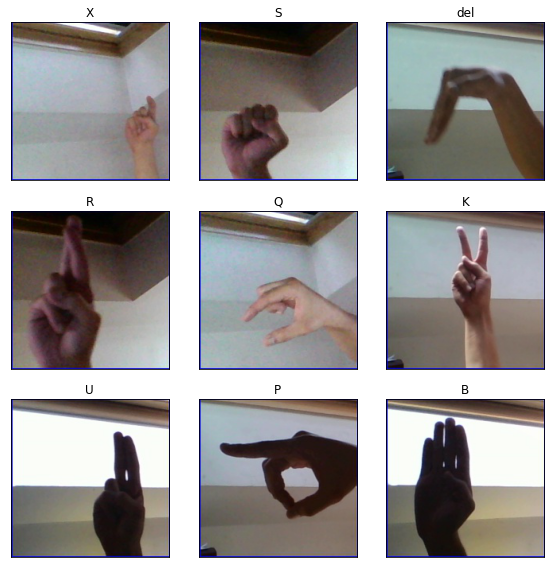

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.Filepath[i]))
    ax.set_title(train_df.Label[i])
plt.tight_layout()
plt.show()

In [8]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_df0, test_df = train_test_split(train_df.sample(frac = 0.05), test_size=0.2, random_state=0)

In [12]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df0,
    x_col='Filepath',
    y_col='Label',
    target_size=(200, 200),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df0,
    x_col='Filepath',
    y_col='Label',
    target_size=(200, 200),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(200, 200),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(200, 200, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

Found 2784 validated image filenames belonging to 29 classes.
Found 696 validated image filenames belonging to 29 classes.
Found 870 validated image filenames belonging to 29 classes.


In [48]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(200, 200, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [49]:
inputs = pretrained_model.input

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)

outputs = Dense(29, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [50]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [51]:
my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              mode='auto')

    ]

In [ ]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=15,
    callbacks = my_callbacks
)

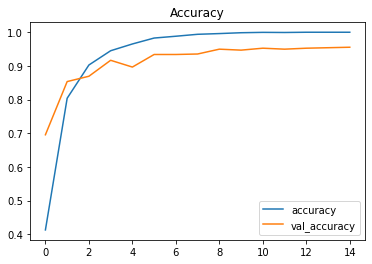

In [18]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

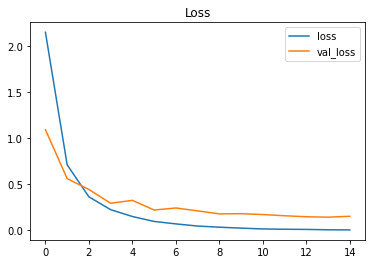

In [19]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [20]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.19315
Test Accuracy: 94.14%


In [21]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['M', 'T', 'V', 'nothing', 'D']


In [22]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           A       0.96      0.96      0.96        26
           B       0.94      0.97      0.95        32
           C       0.90      0.96      0.93        27
           D       0.86      1.00      0.93        25
           E       0.93      0.93      0.93        29
           F       0.96      0.93      0.95        28
           G       0.83      1.00      0.91        29
           H       1.00      0.86      0.93        36
           I       1.00      0.88      0.94        33
           J       0.96      0.86      0.91        29
           K       0.97      0.97      0.97        33
           L       1.00      1.00      1.00        39
           M       0.85      0.92      0.88        37
           N       0.93      0.84      0.88        31
           O       0.97      1.00      0.99        34
           P       1.00      1.00      1.00        22
           Q       1.00      1.00      1.00        36
           R       0.96    

In [23]:
import seaborn as sns

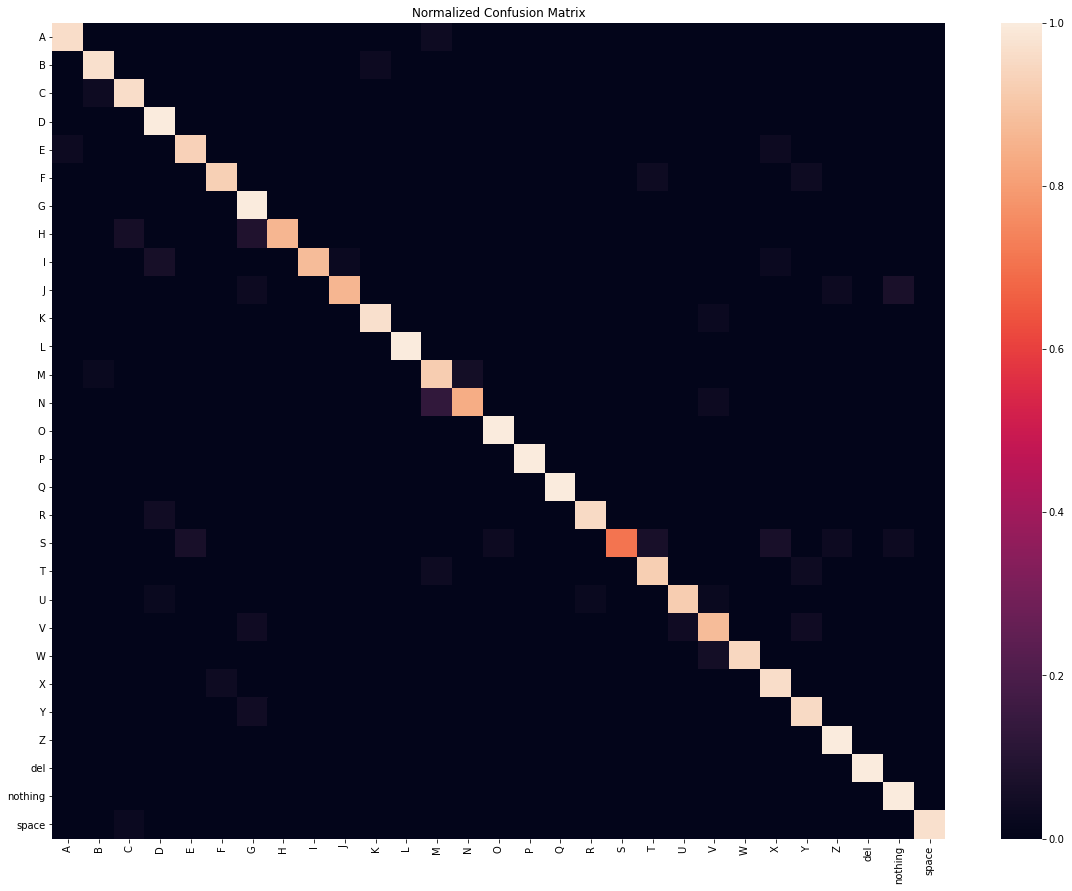

In [24]:
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

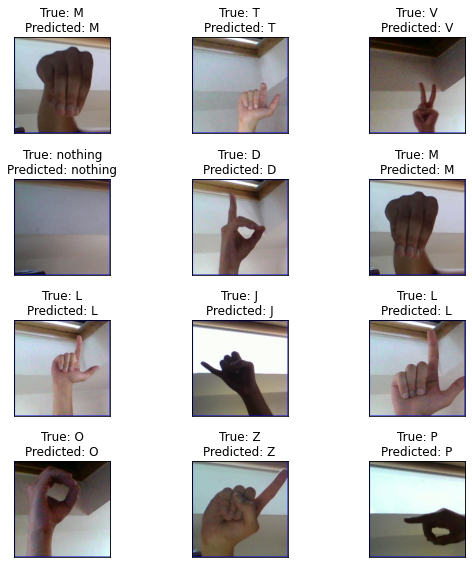

In [25]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [26]:
model.save('asl_alphabet.h5')

/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
